# Strangeon matter EOS generators illustration notebook

First import all the package that will be used.

In [72]:
import numpy as np
import math
import TOVsolver.main as main
import matplotlib.pyplot as plt
from scipy.integrate import ode

The strangeon matter EOS describes the strongly interacting matter in the solid state, and the compact star can be a self-bound quark star composed of strangeon matter. Therefore, in the following we present the bare quark star EOS without a crust.

The constans that we will used in the following:

In [73]:
c = 3e10  # Speed of light in cm/s
G = 6.67428e-8  # Gravitational constant in cm^3/g/s^2 or dyne cm^2/g^2
Msun = 1.989e33  # Solar mass in grams
dyncm2_to_MeVfm3 = 1./(1.6022e33)  # Conversion factor from dyn/cm^2 to MeV/fm^3
gcm3_to_MeVfm3 = 1./(1.7827e12)  # Conversion factor from g/cm^3 to MeV/fm^3
oneoverfm_MeV = 197.33  # Conversion factor for fm to MeV

In [74]:
def Strangeon_compute_EOS(n, theta): 
    """
    Compute the energy density and pressure based on the given parameters.

    Args:
        n (array): An array of n values. Input values of baryon number densities.
        theta (array): An array representing the parameters [epsilon, Nq, ns].
        epsilon: the depth of the potential well; MeV;
        Nq: the number of quarks in a strangeon; 
        ns: the number density of baryons at the surface of the star; fm^-3
        
    Returns:
        tuple: Arrays of energy densities in units of gcm3 and pressures in units of dyncm2.
    """
    
    Nq, epsilon, ns = theta
    
    A12 = 6.2
    A6 = 8.4 
    mq = 300 
    """
    mq: the mass of the quark in this EOS.
    A12 and A6 are fixed throughout the calculation.
    """
   
    sigma = np.sqrt(A6 / (2 * A12)) * (Nq / (3 * ns)) 
   
    energy_density = 2 * epsilon * (A12 * sigma**4 * n**5 - A6 * sigma**2 * n**3) + n * Nq * mq
    pressure = 4 * epsilon * (2 * A12 * sigma**4 * n**5 - A6 * sigma**2 * n**3)
    
    return energy_density*G/c**2/gcm3_to_MeVfm3, pressure*G/c**4/dyncm2_to_MeVfm3


Note that the strangeon matter parameters we input are in the natural unit system. The quentity returned by the Strangeon_compute_EOS function is in the Geometric Unit System. Thus, here, the parameter epsilon and ns are in the units of MeV and fm^-3, then using the conversion factor from  g/cm^3 to MeV/fm^3 and dyn/cm^2 to MeV/fm^3, we can obtain the  quentity of energy density and pressure in the units of cgs. Finally, we convert to the geometrical unit system by adding G/c**2 and G/c**4.


Defining the EOS parameters

Define the strangeon matter EOS that we will use to calculate the energy densities and pressures of the system.
The following is an example of how to define the theta and Nq.
For example, theta=[50, 0.24] means the example values for epsilon and ns:
epsilon in units of MeV, ns in units of fm^-3.
Nq is an integer, e.g. Nq=9, 12, 15, 18, 21, 24, 27

For the definition of parameter n, the minimum value is 3*ns/Nq, the maximum value is about 0.16*8*3/Nq.
Then we can generate,for example, 100 points for the input of the srangeon matter EOS.

Once we define the EOS parameters already, we can use the Strangeon_compute_EOS function to calcute the energy_density and pressure.

In [75]:
Nq=18
epsilon=50
ns=0.24
theta = np.array([Nq, epsilon, ns])
n_min = 3 * theta[2] / theta[0]  
n_max = 0.16 * 8 * 3 / theta[0]   
n_values = np.linspace(n_min, n_max, 100) 

energy_densities, pressures = Strangeon_compute_EOS(n_values, theta)
print("n values:", n_values)
print("Energy densities:", energy_densities)
print("Pressures:", pressures) 

n values: [0.04       0.04175084 0.04350168 0.04525253 0.04700337 0.04875421
 0.05050505 0.05225589 0.05400673 0.05575758 0.05750842 0.05925926
 0.0610101  0.06276094 0.06451178 0.06626263 0.06801347 0.06976431
 0.07151515 0.07326599 0.07501684 0.07676768 0.07851852 0.08026936
 0.0820202  0.08377104 0.08552189 0.08727273 0.08902357 0.09077441
 0.09252525 0.09427609 0.09602694 0.09777778 0.09952862 0.10127946
 0.1030303  0.10478114 0.10653199 0.10828283 0.11003367 0.11178451
 0.11353535 0.1152862  0.11703704 0.11878788 0.12053872 0.12228956
 0.1240404  0.12579125 0.12754209 0.12929293 0.13104377 0.13279461
 0.13454545 0.1362963  0.13804714 0.13979798 0.14154882 0.14329966
 0.14505051 0.14680135 0.14855219 0.15030303 0.15205387 0.15380471
 0.15555556 0.1573064  0.15905724 0.16080808 0.16255892 0.16430976
 0.16606061 0.16781145 0.16956229 0.17131313 0.17306397 0.17481481
 0.17656566 0.1783165  0.18006734 0.18181818 0.18356902 0.18531987
 0.18707071 0.18882155 0.19057239 0.19232323 0.19407

Here below we use the strangeon matter EOS to compute the mass radius curve.

The following code calculates the mass and radius of the strange stars for the given EOS of the strange matter EOS.

Input a given central pressure and central energy density, you will obtain the radius where the pressure is zero and the mass at that radius.

In [76]:
def TOV_def(r, y):
    pressure, mass = y
    energy_density = energy_densities[np.argmin(np.abs(pressures - pressure))]
    dpdr = -(energy_density + pressure) * (mass + 4 * np.pi * r**3 * pressure) / (r * (r - 2 * mass))
    dmdr = 4 * np.pi * r**2 * energy_density
    return [dpdr, dmdr] 


def solve_TOV(central_pressure, central_energy_density):
    """
    Solve the TOV equations for a given central pressure and energy density.
    Args:
        central_pressure (float): The central pressure of the star.
        central_energy_density (float): The central energy density of the star.
    Returns:
        tuple: Radius and mass of the star.
    """   
    
    r_i = 1e-5 
    y_i = [central_pressure,  4/3 * np.pi * r_i**3 * central_energy_density] 
    
    solver = ode(TOV_def).set_integrator('dopri5')
    solver.set_initial_value(y_i, r_i) 
    
    dt = 1e4
    while solver.successful() and solver.y[0] > 0:
        solver.integrate(solver.t + dt)
        
    if solver.successful():
        R = solver.t / 1e5  
        M = solver.y[1] * c**2 / G / Msun 

    return R, M

Solve the TOV equations using each central pressure and energy density

In [87]:
def output_MR(energy_densities, pressures):
    masses=[]
    radii=[]
    for ep, cp in zip(energy_densities, pressures):
        R, M = solve_TOV(central_pressure=cp, central_energy_density=ep)
        radii.append(R)
        masses.append(M)
    MR = np.vstack((radii, masses)).T
    return MR

MR=output_MR(energy_densities, pressures)
print(MR)

[[1.00000000e-10 7.68207958e-34]
 [5.90000000e+00 1.60121280e-01]
 [8.40000000e+00 4.71215006e-01]
 [1.01000000e+01 8.36939236e-01]
 [1.15000000e+01 1.26092789e+00]
 [1.25000000e+01 1.65687654e+00]
 [1.33000000e+01 2.04186596e+00]
 [1.40000000e+01 2.43062385e+00]
 [1.44000000e+01 2.71126853e+00]
 [1.48000000e+01 3.00590503e+00]
 [1.50000000e+01 3.20645334e+00]
 [1.52000000e+01 3.40719998e+00]
 [1.53000000e+01 3.55338800e+00]
 [1.54000000e+01 3.69631034e+00]
 [1.54000000e+01 3.77916629e+00]
 [1.54000000e+01 3.85690313e+00]
 [1.54000000e+01 3.92745803e+00]
 [1.54000000e+01 3.99386808e+00]
 [1.53000000e+01 3.99990214e+00]
 [1.53000000e+01 4.05595027e+00]
 [1.52000000e+01 4.05237910e+00]
 [1.51000000e+01 4.04670012e+00]
 [1.50000000e+01 4.03449036e+00]
 [1.50000000e+01 4.07205745e+00]
 [1.49000000e+01 4.05532944e+00]
 [1.48000000e+01 4.03485856e+00]
 [1.47000000e+01 4.01185858e+00]
 [1.46000000e+01 3.98798041e+00]
 [1.46000000e+01 4.01000581e+00]
 [1.45000000e+01 3.98162747e+00]
 [1.440000

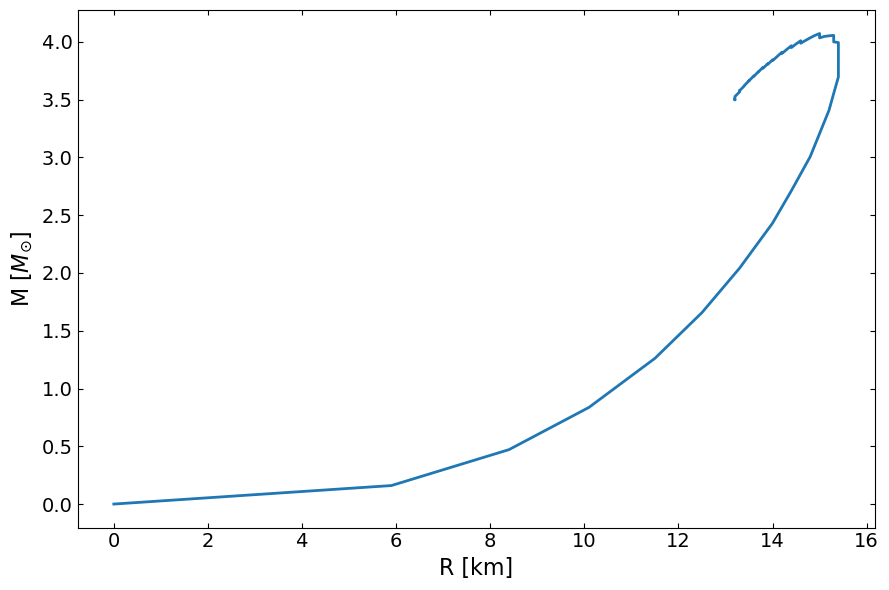

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.plot(MR[:,0] , MR[:,1], lw=2)
ax.set_ylabel(r"M [$M_{\odot}$]", fontsize=16)
ax.set_xlabel("R [km]", fontsize=16)
# ax.set_xlim(8.0, 20.0)
# ax.set_ylim(0, 3)
ax.tick_params(top=1, right=1, which="both", direction="in", labelsize=14)
ax.tick_params(top=1, right=1, which="both", direction="in", labelsize=14)
fig.tight_layout()
plt.show()

You also can use our defined function, 'OutputMR' to compute out what the mass radius curve corresponding to this equation of state.

In [63]:
MR = main.OutputMR(input_file='', density= energy_densities, pressure=pressures).T
print(MR)

[[4.44100000e-21 4.44100000e-21 4.44100000e-21 4.44100000e-21
  4.44100000e-21 4.44100000e-21 4.44100000e-21 4.44100000e-21
  4.44100000e-21 4.44100000e-21 4.44100000e-21 4.44100000e-21
  4.44100000e-21 4.44100000e-21 4.44100000e-21 4.44100000e-21
  4.44100000e-21 4.44100000e-21 4.44100000e-21 4.44100000e-21
  4.44100000e-21 4.44100000e-21 4.44100000e-21 4.44100000e-21
  4.44100000e-21 4.44100000e-21 3.10563596e+00 4.32350845e+00
  5.33392945e+00 5.88865871e+00 5.86512576e+00 6.44826615e+00
  6.41969631e+00 7.02879732e+00 6.99586824e+00 6.96376281e+00
  7.59318495e+00 7.55825322e+00 7.52452468e+00 7.49199392e+00
  7.46065196e+00 7.43048945e+00 7.40149529e+00 7.37365865e+00
  7.34696784e+00 7.32141175e+00 7.29697894e+00 7.93771270e+00
  7.91422534e+00 7.89204887e+00]
 [3.68040952e-65 3.91225143e-65 4.15869787e-65 4.42066884e-65
  4.69914228e-65 4.99515774e-65 5.30982025e-65 5.64430445e-65
  5.99985899e-65 6.37781116e-65 6.77957186e-65 7.20664087e-65
  7.66061246e-65 8.14318132e-65 8.656